#### Use Holoviews to interactively visualize HS2 data from STOQS Parquet request

This Notebook is part of the auv-python project (private repository at https://github.com/mbari-org/auv-python). It demonstrates how to read and make interactive plots of millions of data points accessed from a STOQS database.

To execute it (for example):

```bash
    cd GitHub  # Or other appropriate directory on your computer
    git clone https://github.com/mbari-org/auv-python.git
    cd auv-python
    poetry install
    poetry shell
    cd notebooks
    jupyter-lab
    # Open this notebook and run it from your browser - interactivity does not work in VS Code
```

The urls in the pooch.retrieve() calls  below were generated by going to https://stoqs.shore.mbari.org/stoqs_all_dorado/ and clicking the buttons of the Measured Parameters to be included in the Parquet file. Then clicking the "Measured Parameter Data Access" section and clicking the "Estimate requirements" button to verify that the estimated values are within the available values of the server. 

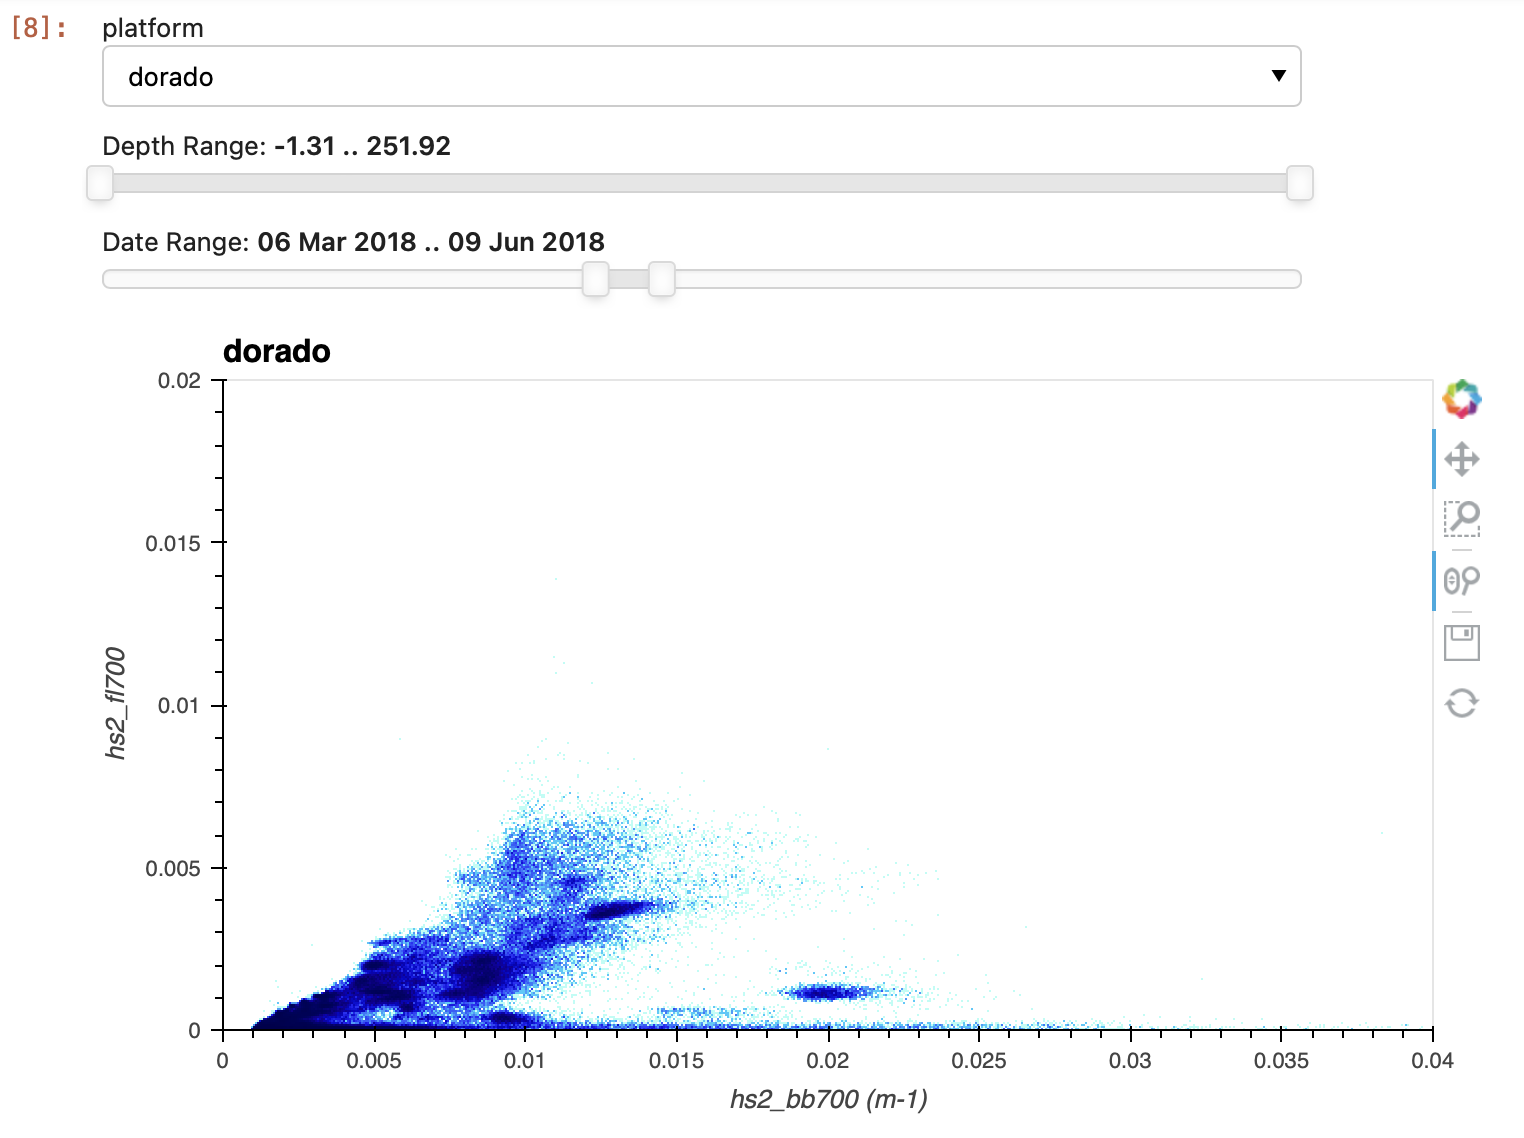

In [1]:
# Executing the last cell results in an interactive plot with Depth and Date range selection widgets, e.g.:
from IPython.display import Image
Image(filename="hvplot_5.9-mpm_screenshot1.png")

In [2]:
import holoviews as hv
import hvplot.pandas
import ipywidgets as widgets
import numpy as np
import pandas as pd
import panel as pn
import pooch
from holoviews.operation.datashader import datashade

NOTICE: When using the below code the known_hash should not be changing. However, if an error message is recieved then change the known_hash value to what it received or "got" instead of what is expected.

In [3]:
%%time
# Can take several minutes to retrieve the data the first time, thereafter it's read from a local cache
data_file = pooch.retrieve(
    url="https://stoqs.shore.mbari.org/stoqs_all_dorado/api/measuredparameter.parquet?parameter__name=biolume_bg_biolume%20%28photons/liter%29&parameter__name=biolume_proxy_adinos&parameter__name=biolume_proxy_diatoms&parameter__name=biolume_proxy_hdinos&parameter__name=ctd1_temperature%20%28degree_Celsius%29&parameter__name=ctd2_temperature%20%28degree_Celsius%29&parameter__name=hs2_bb420%20%28m-1%29&parameter__name=hs2_bb700%20%28m-1%29&parameter__name=hs2_fl700&parameter__name=profile_number&measurement__instantpoint__timevalue__gt=2016-01-01+00%3A00%3A00&measurement__instantpoint__timevalue__lt=2020-12-31+23%3A59%3A59&measurement__depth__gte=-100.0&measurement__depth__lte=10000.0&collect=name&include=activity__name",
    known_hash="2765fd51e659b8335768aa3ba6d22830a88e734c4acc04b4c9054f6aab871f5c",
)
df = pd.read_parquet(data_file)
df.describe()

CPU times: user 6 s, sys: 954 ms, total: 6.95 s
Wall time: 6.48 s


name,biolume_bg_biolume (photons/liter),biolume_proxy_adinos,biolume_proxy_diatoms,biolume_proxy_hdinos,ctd1_temperature (degree_Celsius),ctd2_temperature (degree_Celsius),hs2_bb420 (m-1),hs2_bb700 (m-1),hs2_fl700,profile_number
count,4.376859e+06,1.554146e+06,1.554146e+06,1.554146e+06,4.377483e+06,4.377255e+06,3.775769e+06,3.775680e+06,3.775769e+06,4.377511e+06
mean,1.395215e+10,6.355984e-02,6.120775e-02,5.842985e-02,1.180762e+01,1.178784e+01,4.243722e-03,6.497401e-03,7.222882e-04,1.625920e+02
std,6.663142e+10,1.159976e-01,1.636134e-01,4.050850e-01,1.736753e+00,1.729471e+00,4.331563e-03,1.496655e+00,1.321515e-03,1.117404e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.337319e+00,7.337160e+00,-1.299565e-03,-5.239460e-03,-9.492986e-02,1.000000e+00
25%,0.000000e+00,8.522036e-05,1.069580e-03,0.000000e+00,1.044547e+01,1.041426e+01,2.001787e-03,1.667980e-03,8.242336e-05,7.200000e+01
50%,3.851980e+08,1.694408e-02,1.514859e-02,0.000000e+00,1.177027e+01,1.175009e+01,3.115333e-03,3.124387e-03,2.382901e-04,1.450000e+02
75%,7.175917e+09,8.231843e-02,4.571551e-02,0.000000e+00,1.300337e+01,1.298939e+01,5.224731e-03,6.240779e-03,8.226301e-04,2.390000e+02
max,5.530390e+12,1.880321e+00,1.902550e+01,2.863179e+01,1.831997e+01,1.831909e+01,9.945312e-02,2.662765e+03,9.775415e-02,4.480000e+02


In [4]:
# Remove egregious backscatter values
df["hs2_bb700 (m-1)"][df["hs2_bb700 (m-1)"] > 0.1] = np.nan

# Turn multi-indexes into regular columns in a dataframe modified
dfm = df.reset_index()
dfm.describe()

name,timevalue,depth,latitude,longitude,biolume_bg_biolume (photons/liter),biolume_proxy_adinos,biolume_proxy_diatoms,biolume_proxy_hdinos,ctd1_temperature (degree_Celsius),ctd2_temperature (degree_Celsius),hs2_bb420 (m-1),hs2_bb700 (m-1),hs2_fl700,profile_number
count,4377511,4.377511e+06,4.377511e+06,4.377511e+06,4.376859e+06,1.554146e+06,1.554146e+06,1.554146e+06,4.377483e+06,4.377255e+06,3.775769e+06,3.773710e+06,3.775769e+06,4.377511e+06
mean,2018-12-29 21:32:23.667593728,3.371976e+01,3.678165e+01,-1.219394e+02,1.395215e+10,6.355984e-02,6.120775e-02,5.842985e-02,1.180762e+01,1.178784e+01,4.243722e-03,4.763386e-03,7.222882e-04,1.625920e+02
min,2016-03-30 17:03:47,-1.305286e+00,3.660523e+01,-1.223752e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.337319e+00,7.337160e+00,-1.299565e-03,-5.239460e-03,-9.492986e-02,1.000000e+00
25%,2017-10-03 03:55:35.500000,4.141015e+00,3.673058e+01,-1.219884e+02,0.000000e+00,8.522036e-05,1.069580e-03,0.000000e+00,1.044547e+01,1.041426e+01,2.001787e-03,1.667471e-03,8.242336e-05,7.200000e+01
50%,2019-01-30 13:58:34,2.450916e+01,3.678966e+01,-1.219242e+02,3.851980e+08,1.694408e-02,1.514859e-02,0.000000e+00,1.177027e+01,1.175009e+01,3.115333e-03,3.122117e-03,2.382901e-04,1.450000e+02
75%,2020-08-06 06:23:02.500000,5.170796e+01,3.682673e+01,-1.218733e+02,7.175917e+09,8.231843e-02,4.571551e-02,0.000000e+00,1.300337e+01,1.298939e+01,5.224731e-03,6.233687e-03,8.226301e-04,2.390000e+02
max,2020-12-04 15:27:13,2.519176e+02,3.692717e+01,-1.218085e+02,5.530390e+12,1.880321e+00,1.902550e+01,2.863179e+01,1.831997e+01,1.831909e+01,9.945312e-02,9.993627e-02,9.775415e-02,4.480000e+02
std,NaN,3.579781e+01,6.467158e-02,8.721381e-02,6.663142e+10,1.159976e-01,1.636134e-01,4.050850e-01,1.736753e+00,1.729471e+00,4.331563e-03,5.399512e-03,1.321515e-03,1.117404e+02


In [ ]:
# Initial Datashade scatter plot of backscatter and flouresence with no selection widgets
pts = hv.Points(dfm, ['hs2_bb700 (m-1)', 'hs2_fl700'])
datashade(pts).opts(hv.opts.RGB(width=800, height=500))

In [ ]:
# Datashader timeseries plot of chlorophyll 
bb700_pts = hv.Points(dfm, ['timevalue', 'hs2_bb700 (m-1)'])
datashade(bb700_pts).opts(hv.opts.RGB(width=900, height=300))

In [ ]:
# Function to return a generic range selection widget for any column in the dataframe
def sliderType(colmn, range_name):
    return pn.widgets.RangeSlider(
        start=dfm[colmn].min(),
        end=dfm[colmn].max(),
        value=(dfm[colmn].min(), dfm[colmn].max()),
        name=range_name,
        width=600,
        step=dfm[colmn].max() / 200,
    )

In [ ]:
# Datashade scatter plot of backscatter and flouresence with Depth and Date selection widgets
dsticker = pn.widgets.Select(options=['dorado', 'dorado_Gulper'], name='platform')
def dsAUV_df(dsticker):
    df = dfm[dfm['platform'] == dsticker]
    return df

dsdf = hvplot.bind(dsAUV_df, dsticker).interactive()

# Dynamic hvplot will not work unless we use this dskind
dskind = pn.widgets.Select(name='kind', value='scatter', options=['scatter'], visible=False)
dsd = sliderType("depth", "Depth Range") 
dst = pn.widgets.DateRangeSlider(
    start=dfm.timevalue.min(),
    end=dfm.timevalue.max(),
    value=(dfm.timevalue.min(), dfm.timevalue.max()),
    name="Date Range",
)
dsplt = dsplt = dsdf[
    (dsdf.depth >= dsd.param.value_start)
    & (dsdf.depth <= dsd.param.value_end)
    & (dsdf.timevalue >= dst.param.value_start)
    & (dsdf.timevalue <= dst.param.value_end)
].hvplot(
    kind=dskind,
    x="hs2_bb700 (m-1)",
    y="hs2_fl700",
    grid=False,
    title=dsticker,
    datashade=True,
    xlim=(0, 0.06),
    ylim=(0, 0.02),
    dynamic=True,
    height=400,
)
dsplt